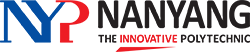

# ITB251 Assignment - Task 2: Topic Modelling

You are required to build a topic model to help understand the text in the review to a particular topic. This analysis aims to be accompaniment to the results of the sentiment classification and helps businesses to identify main topic that customers are concern about.

Complete the following sub-tasks:
1.	**Data Understanding**: Examine the dataset
2.	**Data Preparation**: Prepares the data and all necessary pre-processing tasks
3.	**Modelling**: Identify the suitable topic number for the topic model
4.	**Evaluation**: Evaluates the results and identify the topic

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in the Jupyter notebook**. 

**Done by: \<Zowie Ong 212345X>**

## Import libraries and download the packages

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize 
stop_words = set(stopwords.words('english')) 

from nltk.probability import FreqDist
import string

import gensim
from gensim import corpora

import pandas as pd

import string
from pathlib import Path
from pprint import pprint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zoe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zoe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zoe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Read the dataset

In [19]:
df = pd.read_csv('shopping_reviews.csv',index_col=[0])

# reset index
df.index = range(len(df.index))
df = df.iloc[:100]

print(df.shape)
df.head()

(100, 6)


,review_id,date,name,categories,text,stars
0,Af6Jnf8F5xBliuixStWF8g,2019-09-20,"""Soccer Zone""",Shopping;Sporting Goods,I'll admit it. I caught World Cup fever in 20...,4
1,j-6-I55-9EiKNGAjoLHx9A,2020-06-30,"""Fye""",Shopping;Books;Mags;Music & Video;Music & DVDs,This store has gone through some management ch...,4
2,wCwl4NC1CxkRIAg2RcLzig,2020-09-28,"""By Design""",Home & Garden;Furniture Stores;Shopping,By Design sells funky ultra modern furniture. ...,3
3,PwSZrByRWrZ5x7QTq7V2PA,2020-05-10,"""Star Nursery""",Nurseries & Gardening;Home & Garden;Shopping,"I don't have much of a greenthumb, thankfully ...",4
4,yHmRAHgjgqucJcUG3to7-Q,2020-08-26,"""Sports Authority""",Sporting Goods;Shopping,I am only ever going to this Sports Authority ...,5


## Data Understanding



#### How many rows are in the dataset?

In [20]:
print(df.shape[0], 'rows')

100 rows


## Dates 

In [21]:
type(df['date'][0])

str

Convert dates from string to datetime objects

In [22]:
from datetime import datetime

date_str = df['date']
df['year']=''
df['month']=''

for index, date in enumerate(date_str):
    date_obj = datetime.strptime(date, '%Y-%m-%d').date()
    df['date'][index] = date_obj
    df['year'][index]=date_obj.strftime('%Y')
    df['month'][index]=date_obj.strftime('%B')

print(type(df['date'][0]))
print(df['date'][0])  # printed in default format

<class 'datetime.date'>
2019-09-20


C:\Users\zoe\AppData\Local\Temp/ipykernel_2728/3672976536.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'][index]=date_obj.strftime('%Y')
C:\Users\zoe\AppData\Local\Temp/ipykernel_2728/3672976536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'][index]=date_obj.strftime('%B')
C:\Users\zoe\AppData\Local\Temp/ipykernel_2728/3672976536.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][index] = da

In [23]:
df['date'][0].year

2019

When was the oldest and newest records made?

In [24]:
print('oldest record is', min(df['date']))
print('newest record is', max(df['date']))

oldest record is 2019-02-05
newest record is 2020-12-17


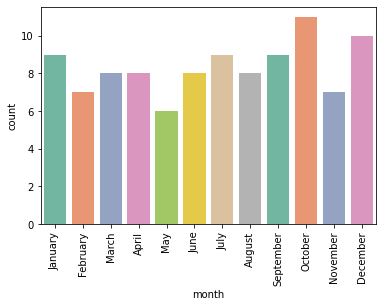

In [25]:
# sort by months
import calendar
df['month'] = pd.Categorical(df.month, categories=calendar.month_name[1:], ordered=True)

df.sort_values('month', inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt

color = sns.color_palette('Set2')
plt.xticks(rotation=90)
sns.countplot(x='month', data=df, palette = color)

plt.show()

June and July have the highest number of reviews in total, whereas Feburary has the least number of reviews.

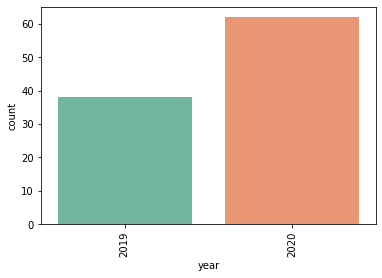

In [26]:
# sort by year
df.sort_values('year', inplace=True)

color = sns.color_palette('Set2')
plt.xticks(rotation=90)
sns.countplot(x='year', data=df, palette = color)

plt.show()

There are about 5000 more reviews in 2020 as compared to 2019.

## Categories 

#### Tokenize words in 'categories' by using ';' as a seperator

In [27]:

from nltk.tokenize import RegexpTokenizer

categories = list(df['categories'])

pattern = RegexpTokenizer(';', gaps= True)

for index, one in enumerate(categories):
    categories[index] = pattern.tokenize(one)


#### combine all words into one list

In [28]:
firstcats = categories[0]
for i in categories:
    firstcats.extend(i)

print(firstcats[:10])

['Watch Repair', 'Jewelry Repair', 'Shopping', 'Local Services', 'Jewelry', 'Watch Repair', 'Jewelry Repair', 'Shopping', 'Local Services', 'Jewelry']


#### generate frequency distribution of categories

This tells us that there are 73 distinct categories in the dataset as labelled in "categories"


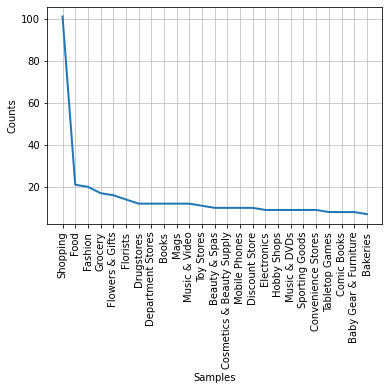

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [29]:
# generate frequency for all the words
freq_dist = nltk.FreqDist(firstcats)

# show the top few results
print('This tells us that there are', len(freq_dist) ,'distinct categories in the dataset as labelled in "categories"')

# what are the top 25 categories
freq_dist.plot(25, cumulative=False)

Shopping has a significantly higher count than other categories, followed by 

## Data Preparation


- remove unnecessary columns
- remove duplicate rows


clean the text data
- remove stopwords, words with 2 characters or lesser, punctuation and perform stemming

Remove columns that will not help in topic modelling analysis of review text.

In [30]:
# drop unnecessary columns
df.drop(columns=['date', 'name', 'categories'], inplace=True)
df.head()

,review_id,text,stars,year,month
8,sVo3TZJ36rMKfda3im1VLA,The first of many wedding-related reviews I'll...,4,2019,July
96,E5TiwMs2KbI11Fmqw94M-Q,Located in the Forum Shops between Express and...,4,2019,April
51,6VCYCI1eV2Zh6XPoOnulww,"This Walmart is okay.\nAlways packed, so its e...",3,2019,April
81,97QpmPPhwNI4oUavckRgTA,One would think this place's touristy location...,4,2019,October
71,ZKEIW7ms6n53PbOjnyqNyg,"In the middle of a weekday afternoon, I am sur...",2,2019,April


Remove duplicate rows, if any

In [31]:
# remove duplicate rows
df.drop_duplicates(inplace=True)
print('Number of rows after removing duplicates is', len(df))

Number of rows after removing duplicates is 100


### Clean text

Remove digits, words with less than 2 characters, punctuation, stopwords, perform lemmatization and tokenize text.

- This is done to reduce noise and dimensionality in the dataset. Words that would not help in the categorization or do not carry much meaning such as punctuation, filler words (on, to, of), are removed.

- words are not converted to lowercase, to be able to identify nouns using capitalised first letters

In [32]:

import string
import gensim
from nltk.corpus import stopwords

lemma = WordNetLemmatizer()

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)


def clean(doc):
    
    all_words_clean = []
    for word in doc:
        if word not in stop and not any(c.isdigit() for c in word) and len(word)>5:
            punc_free = ''.join([ch for ch in word if ch not in string.punctuation])
            if punc_free and not word.isdigit():
                all_words_clean.append(lemma.lemmatize(punc_free))

    return all_words_clean


In [33]:
# import re
df['cl_text'] = ''

# word tokenize text
df['cl_text'] = df['text'].apply(lambda x: word_tokenize(x))

# apply function to text in dataframe; remove words with 4 characters or less, digits, 
# Punctuation and Stopwords, perform stemming
doc_clean = [clean(doc) for doc in df['cl_text']]


### Perform part-of-speech (POS) tagging

In [34]:
df['cl_text'] = doc_clean
df.head()

,review_id,text,stars,year,month,cl_text
8,sVo3TZJ36rMKfda3im1VLA,The first of many wedding-related reviews I'll...,4,2019,July,"[weddingrelated, review, writing, month, aweso..."
96,E5TiwMs2KbI11Fmqw94M-Q,Located in the Forum Shops between Express and...,4,2019,April,"[Located, Express, Tuesday, walked, plenty, ca..."
51,6VCYCI1eV2Zh6XPoOnulww,"This Walmart is okay.\nAlways packed, so its e...",3,2019,April,"[Walmart, Always, packed, expected, cluttered,..."
81,97QpmPPhwNI4oUavckRgTA,One would think this place's touristy location...,4,2019,October,"[touristy, location, offering, overpriced, cav..."
71,ZKEIW7ms6n53PbOjnyqNyg,"In the middle of a weekday afternoon, I am sur...",2,2019,April,"[middle, weekday, afternoon, surprised, parkin..."


In [35]:

def tagPOS(text):
    tagged_text = []

        #  Using a Tagger. Which is part-of-speech tagger or POS-tagger.  
    tagged = nltk.pos_tag(text) 
    tagged_text.extend(tagged)

    return tagged_text


# Next we will use lamda to apply the tagPOS function to each review.

df['POS_txt'] = df['cl_text'].apply(lambda x: tagPOS(x))

df.head()

,review_id,text,stars,year,month,cl_text,POS_txt
8,sVo3TZJ36rMKfda3im1VLA,The first of many wedding-related reviews I'll...,4,2019,July,"[weddingrelated, review, writing, month, aweso...","[(weddingrelated, VBN), (review, NN), (writing..."
96,E5TiwMs2KbI11Fmqw94M-Q,Located in the Forum Shops between Express and...,4,2019,April,"[Located, Express, Tuesday, walked, plenty, ca...","[(Located, VBN), (Express, NNP), (Tuesday, NNP..."
51,6VCYCI1eV2Zh6XPoOnulww,"This Walmart is okay.\nAlways packed, so its e...",3,2019,April,"[Walmart, Always, packed, expected, cluttered,...","[(Walmart, NNP), (Always, NNP), (packed, VBD),..."
81,97QpmPPhwNI4oUavckRgTA,One would think this place's touristy location...,4,2019,October,"[touristy, location, offering, overpriced, cav...","[(touristy, JJ), (location, NN), (offering, NN..."
71,ZKEIW7ms6n53PbOjnyqNyg,"In the middle of a weekday afternoon, I am sur...",2,2019,April,"[middle, weekday, afternoon, surprised, parkin...","[(middle, JJ), (weekday, JJ), (afternoon, NN),..."


In [36]:
df['POS_txt'][0]

[('caught', 'NN'),
 ('decided', 'VBD'),
 ('playing', 'VBG'),
 ('soccer', 'NN'),
 ('Shockingly', 'NNP'),
 ('school', 'NN'),
 ('cleat', 'NN'),
 ('guard', 'NN'),
 ('soccer', 'NN'),
 ('Google', 'NNP'),
 ('search', 'NN'),
 ('headed', 'VBD'),
 ('Soccer', 'NNP'),
 ('supply', 'NN'),
 ('incredibly', 'RB'),
 ('wellstocked', 'VBD'),
 ('variety', 'NN'),
 ('jersey', 'NN'),
 ('cleat', 'NN'),
 ('guard', 'NN'),
 ('anything', 'NN'),
 ('visited', 'JJ'),
 ('helpful', 'JJ'),
 ('friendly', 'RB'),
 ('talked', 'VBD'),
 ('needed', 'VBN'),
 ('started', 'VBD')]

In [37]:
from nltk import ne_chunk
nltk.download('words')
nltk.download('maxent_ne_chunker')

import re

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\zoe\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\zoe\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


## Perform NER

Extract entities from text using named entity recognition (NER).

In [38]:
tagged_text_list=df['POS_txt']

allnoun = []
allentity = []
noexclude = []

include = ['PERSON', 'NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT','WORK_OF_ART','LAW','LANGUAGE']
exclude = ['DATE','TIME','PERCENT','MONEY','QUANTITY','ORDINAL','CARDINAL']

for text in tagged_text_list:

    nnplist = []
    includelist = []
    excludelist = []
    
    res_chunk = ne_chunk(text)

    for x in str(res_chunk).split('\n'):
        if '/NNP' in x:
            nnplist.append(x)
            
            if re.search('[A-Z]+', x) != None:
                entity = re.search('[A-Z]+', x).group()
                if entity in include:
                    includelist.append(x)
#                   only included identified named entities that are in 'include'

                if entity not in exclude:
                    excludelist.append(x)
#                   only excluded named entities in 'exclude'. include other named entities and 'NNP' terms.
    
    allnoun.append(nnplist)
    allentity.append(includelist)
    noexclude.append(excludelist)



After trying various feature sets, the feature set which yields the best results is to include terms with 'NNP' tag, disregarding if the term was given a named entity tag.

Visualize entities in the first text

In [39]:
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

C:\Users\zoe\AppData\Roaming\Python\Python39\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


In [40]:
# visualize first text
firsttext = nlp(df['text'][0])
displacy.render(firsttext, style='ent', jupyter = True)

## Modelling
Perform the necessary steps and explain the rationale taken here.



Create a document-term matrix using bag of words approach.

In [41]:
ent_dictionary = corpora.Dictionary(allentity)
entities_doc_term_matrix = [ent_dictionary.doc2bow(doc) for doc in allentity]

In [42]:
ex_dictionary = corpora.Dictionary(noexclude)
excluded_doc_term_matrix = [ex_dictionary.doc2bow(doc) for doc in noexclude]

In [43]:
dictionary = corpora.Dictionary(allnoun)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in allnoun]

Using Latent Dirichlet allocation (LDA) model, trial and error with the number of topics to find the best number of topics and lowest perplexity for the various corpora.
- Only include relevant named entities
- all NNP and named entities except excluded entities
- all NNP terms

In [44]:
allp = []

import random
seed = random.seed(15)

topic_num = 6
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(entities_doc_term_matrix, num_topics = topic_num, id2word = ent_dictionary, passes=25, random_state=seed)

allp.append(ldamodel.log_perplexity(entities_doc_term_matrix))
print('Perplexity: ', ldamodel.log_perplexity(entities_doc_term_matrix))

Perplexity:  -5.905780968223362


In [45]:

topic_num = 6
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(excluded_doc_term_matrix, num_topics = topic_num, id2word = ex_dictionary, passes=25, random_state=seed)

allp.append(ldamodel.log_perplexity(excluded_doc_term_matrix))
print('Perplexity: ', ldamodel.log_perplexity(excluded_doc_term_matrix))

Perplexity:  -6.4307303129159195


In [46]:

topic_num = 6
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics = topic_num, id2word = dictionary, passes=25, random_state=seed)

allp.append(ldamodel.log_perplexity(doc_term_matrix))
print('Perplexity: ', ldamodel.log_perplexity(doc_term_matrix))

Perplexity:  -6.409617715951788


In [47]:
featursetnames = ['Only include relevant named entities', 'all NNP and named entities except excluded entities', 'all NNP terms']

def takeSecond(e):
    return e[1]

compare = zip(featursetnames, allp)
pprint(sorted(compare,key=takeSecond))

[('all NNP and named entities except excluded entities', -6.430730307308521),
 ('all NNP terms', -6.409617748957971),
 ('Only include relevant named entities', -5.9057809765535625)]


In all models, the only difference is the feature set used.
The feature set that produces the lowest perplexity is 'all NNP terms'. All terms tagged with 'NNP' are included, disregarding the named entity tag.

Hence, the model that uses 'All NNP terms' will be used in identifying topics.

## Evaluation
Perform the necessary steps and explain the rationale taken here.



#### Visualize the topic clusters

In [54]:
type(seed)

NoneType

In [49]:

# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# visualize the topics and keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, seed)
vis

C:\Users\zoe\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.110066  0.125217       1        1  21.382785
2     -0.158920  0.070018       2        1  21.170271
5     -0.000850 -0.045598       3        1  17.200118
0      0.024084 -0.067856       4        1  15.696156
1      0.014089 -0.045465       5        1  12.362828
4      0.011531 -0.036316       6        1  12.187842, topic_info=                                                  Term      Freq     Total  \
20                                (PERSON Samurai/NNP)  5.000000  5.000000   
10                          (ORGANIZATION WalMart/NNP)  2.000000  2.000000   
11                               (PERSON Cadillac/NNP)  1.000000  1.000000   
144                               (PERSON Shopper/NNP)  1.000000  1.000000   
29                                          Friday/NNP  1.000000  1.000000   
..                                                 ...       ...       ...   
207    (ORGANIZATION African/NNP Polish/NNP Russian...  0.557727  1.009332   
100                             (PERSON Charlotte/NNP)  0.557534  1.475162   
117                               (GPE California/NNP)  0.558103  1.526105   
10                          (ORGANIZATION WalMart/NNP)  1.035613  2.884913   
46                                    (GPE Groovy/NNP)  0.557700  1.569243   

    Category  logprob  loglift  
20   Default  30.0000  30.0000  
10   Default  29.0000  29.0000  
11   Default  28.0000  28.0000  
144  Default  27.0000  27.0000  
29   Default  26.0000  26.0000  
..       ...      ...      ...  
207   Topic6  -4.1386   1.5116  
100   Topic6  -4.1390   1.1317  
117   Topic6  -4.1380   1.0988  
10    Topic6  -3.5198   1.0802  
46    Topic6  -4.1387   1.0702  

[219 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
13        2  0.892711       Camelback/NNP
14        2  0.892711          Comics/NNP
15        2  0.892711         Forget/NNP)
16        2  0.892711         Phoenix/NNP
17        2  0.892711         Samurai/NNP
...     ...       ...                 ...
176       6  0.990750      Walltowall/NNP
154       3  0.605666         Walmart/NNP
22        2  0.892711       Wednesday/NNP
225       1  0.592630          kaufen/NNP
226       1  0.901449    Überraschung/NNP

[190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 1, 2, 5])

From the visualization, the topics are:

#### 1. Sunday activities / activities around luxury resorts
- This topic mentions Encore Canada, which is a hotel & resort, which is famous for its entertainment venue, casino, and sports stadium.
- Scottsdale is also a top term. Scottsdale is known as "The World's Finest Golf Destination". This city is known for outdoor recreational opportunities such as hiking, biking, and golfing, and its luxury resorts, spas, and shopping.
- Verizon refers to the American telecommunication company. Internet is also a term in the topic, which could mean that many reviews mention purchasing internet from Verizon
- Henderson is well-known for its valley and canyon. Waterfront and Henderson are on the same topic as both have scenic views.
- Shopping, Princes Street, and Vuitton all refer to buying luxury goods.

#### 2. Shopping, entertainment, and dining in large cities.
- Toronto, Montreal, and Phoenix are large cities in urban areas, with a variety of shopping, entertainment, and dining options.
- Shopping referred to other terms like Trader (Trader Joe's - Groceries), Sephora (makeup), and Buffalo Exchange (fashion). 
- Activities on this topic can be done on all days of the week

#### 3. Fashion, gardening, drugstores
- Various fashion brands are mentioned such as Nordstrom, Chanel, Banana Republic, and Burberry
- Gardening is referred through the Associated supply (agriculture company), laurel (plant), and pebbles (decorative gardening)
- Walgreens is a drugstore corporation in America. The leaves of a laurel also has medical benefits.


#### 4. Christmas shopping and local markets.
- There is mention of Christmas, which could refer to buying food in preparation for Christmas.
- Such shopping is frequently done at Walmart, Jean-Talon Market, Barnes & Noble, Amazon, Safeway, and Albertsons.
- The german word 'Beratung' is also a relevant term. This translates to consultation and can be used in the context of a doctor's appointment.


#### 5. Halloween and furniture shopping 
- There are many mentions of Halloween and fashion, where reviews could be talking about purchasing clothes, costumes, candy, or decorations for Halloween.
- Ashley furniture and home store are also mentioned, meaning that a portion of the reviews talks about purchasing from this store.
- Groupon is an e-commerce marketplace where users can find vouchers or discounts for department stores like Costco.
- Places like Costco (department store), goodwill (thrift store), Marshalls (department store), and Neonopolis (shopping mall) have a wide selection of Halloween-themed products and furniture as well.


#### 6. Food and fashion
- Target (department store), Christmas, and Halloween are relevant terms. This points out that the reviews on this topic could mention purchasing Christmas or Halloween goods at Target.
- Starbucks and Mexican Coca-Cola (sweetened with white sugar instead of the high-fructose corn syrup used in the U.S.) are sought after by people in America. These reviews could have mentioned that they were able to find these drinks at that Target outlet.
- Princes Street is the main street in the city of Edinburgh, Scotland. The street is known for its many shops and businesses.
- Biltmore Fashion Park is an upscale outdoor shopping center and is known for its high-end fashion and luxury retailers, as well as its dining options and other amenities.
- The terms in this topic are direct to shopping for food (Christmas dinner, Halloween candy, Starbucks, Mexican Coca-Cola) and fashion (Target, Princess Street Edinburgh, Biltmore Fashion Park).



In [50]:

filenames = df['review_id']

print('\nFile name and its corresponding topic id with probability:')
dic_topic_doc = {}
for index, doc in enumerate(allnoun):
    #for doc in doc_clean:
    bow = dictionary.doc2bow(doc)

    #get topic distribution of the ldamodel
    t = ldamodel.get_document_topics(bow)

    #sort the probability value in descending order to extract the top contributing topic id
    sorted_t = sorted(t, key=lambda x: x[1], reverse=True)

    #print only the filename 
    print(filenames[index],sorted_t)

    #get the top scoring item
    top_item = sorted_t.pop(0)

    #create dictionary and keep key as topic id and filename and probability in tuple as value
    dic_topic_doc.setdefault(top_item[0],[]).append((filenames[index],top_item[1]))


File name and its corresponding topic id with probability:
Af6Jnf8F5xBliuixStWF8g [(0, 0.58331156), (4, 0.08333828), (1, 0.08333814), (5, 0.08333766), (2, 0.08333721), (3, 0.083337136)]
j-6-I55-9EiKNGAjoLHx9A [(3, 0.72221553), (4, 0.055557042), (1, 0.055556998), (0, 0.055556867), (5, 0.055556856), (2, 0.05555673)]
wCwl4NC1CxkRIAg2RcLzig [(2, 0.8332959), (5, 0.033365097), (4, 0.0333349), (1, 0.03333486), (0, 0.03333472), (3, 0.033334557)]
PwSZrByRWrZ5x7QTq7V2PA [(3, 0.5833062), (4, 0.08333936), (1, 0.083339185), (0, 0.08333864), (5, 0.083338596), (2, 0.08333806)]
yHmRAHgjgqucJcUG3to7-Q [(4, 0.8808799), (1, 0.023879768), (0, 0.023810126), (5, 0.02381012), (2, 0.023810064), (3, 0.023810053)]
bHaZK6l9z0eort2jzPfweQ [(2, 0.93055284), (4, 0.0138894925), (1, 0.013889476), (0, 0.013889425), (5, 0.013889422), (3, 0.013889362)]
x5U-Cfb3Q7KP4fr9g-fs_g [(2, 0.583307), (4, 0.08333919), (1, 0.08333902), (0, 0.08333849), (5, 0.08333845), (3, 0.083337836)]
LIbIcaLg039uFJtpCwBFaw [(5, 0.5833113), (4, 

In [51]:

print('\nTopic id, number of documents, list of documents with probability and represented topic words:')

word_num = 5 # display top 5 words with highest term weight in each topic

for key,value in dic_topic_doc.items():
    sorted_value = sorted(value, key=lambda x: x[1], reverse=True)

    #print the topic word and most represented doc
    print(ldamodel.print_topic(key,word_num), '\n')


Topic id, number of documents, list of documents with probability and represented topic words:
0.025*"  (PERSON Filipino/NNP)" + 0.013*"  Saturday/NNP" + 0.013*"  Beyond/NNP" + 0.013*"  (GPE Chinese/NNP)" + 0.013*"  (PERSON Eglinton/NNP)" 

0.020*"  kaufen/NNP" + 0.020*"  (PERSON Blackburn/NNP)" + 0.020*"  (PERSON Buybuy/NNP)" + 0.020*"  (GPE Thankyou/NNP)" + 0.020*"  Tuesday/NNP" 

0.079*"  (PERSON Samurai/NNP)" + 0.031*"  (PERSON Walmart/NNP)" + 0.021*"  (PERSON Phoenix/NNP)" + 0.021*"  (PERSON Samurai/NNP Comics/NNP)" + 0.021*"  (PERSON Batman/NNP)" 

0.030*"  (PERSON Cadillac/NNP)" + 0.030*"  (ORGANIZATION WalMart/NNP)" + 0.016*"  (GPE California/NNP)" + 0.016*"  (ORGANIZATION RUNNING/NNP Target/NNP)" + 0.016*"  Pittsburgh/NNP" 

0.025*"  (ORGANIZATION Intellivision/NNP)" + 0.025*"  Walmart/NNP" + 0.013*"  Beyond/NNP" + 0.013*"  (GPE Groovy/NNP)" + 0.013*"  PacMan/NNP" 

0.042*"  (ORGANIZATION WalMart/NNP)" + 0.028*"  Friday/NNP" + 0.028*"  (PERSON Shopper/NNP)" + 0.028*"  Otherwi

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.